# Disruption type analysis

In [16]:
import json
import numpy as np

import os

# Automatically get the latest scenario folder
scenario_folder_path = "../logs/scenarios/"
latest_folder = max([f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")], key=lambda x: int(x.split('_')[-1].replace('.json', '')))

latest_folder = "scenario_folder_0857.json"

file_path = os.path.join(scenario_folder_path, latest_folder)

# extract the id from the file path
id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {id}")



# Load the JSON data from the file
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']

# Initialize a dictionary to store the results
results = {}

# Initialize lists to store all probability values
all_probabilities = []

# Extract the data_folder from the file which is just called "data_folder" as key in the json
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Iterate over each scenario in the JSON data
for scenario_name, scenario_data in scenarios.items():
    # Initialize lists to store aircraft IDs for each disruption type
    fully_disrupted_aircraft = []
    uncertain_disrupted_aircraft = []
    not_disrupted_aircraft = []

    all_aircraft_ids = scenario_data['aircraft_ids']
    
    # Get the list of disruptions for the current scenario
    disruptions = scenario_data['disruptions']['disruptions']
    
    # Track which aircraft have disruptions
    aircraft_with_disruptions = set()

    # Process each disruption in the list
    for disruption in disruptions:
        aircraft_id = disruption['aircraft_id']
        probability = disruption['probability']
        
        # Add aircraft to tracking set
        aircraft_with_disruptions.add(aircraft_id)
        
        # Add probability to list of all probabilities
        all_probabilities.append(probability)

        # Categorize the disruption based on the probability value
        if probability == 1.0:
            fully_disrupted_aircraft.append(aircraft_id)
        elif probability == 0.0:
            not_disrupted_aircraft.append(aircraft_id)
        elif 0 < probability < 1:
            uncertain_disrupted_aircraft.append(aircraft_id)
        else:
            print(f"Unexpected probability value {probability} for aircraft {aircraft_id} in scenario {scenario_name}")
    
    # Add aircraft without any disruptions to not_disrupted_aircraft
    for aircraft_id in all_aircraft_ids:
        if aircraft_id not in aircraft_with_disruptions:
            not_disrupted_aircraft.append(aircraft_id)
            
    # Calculate the counts for each disruption type
    num_fully_disrupted = len(fully_disrupted_aircraft)
    num_uncertain_disrupted = len(uncertain_disrupted_aircraft)
    num_not_disrupted = len(not_disrupted_aircraft)
    total_disruptions = num_fully_disrupted + num_uncertain_disrupted + num_not_disrupted

    # Store the results for the current scenario
    results[scenario_name] = {
        'fully_disrupted_aircraft': fully_disrupted_aircraft,
        'uncertain_disrupted_aircraft': uncertain_disrupted_aircraft,
        'not_disrupted_aircraft': not_disrupted_aircraft,
        'num_fully_disrupted': num_fully_disrupted,
        'num_uncertain_disrupted': num_uncertain_disrupted,
        'num_not_disrupted': num_not_disrupted,
        'total_disruptions': total_disruptions
    }


# Calculate average number of disruptions per type across all scenarios
total_scenarios = len(results)
avg_fully_disrupted = sum(metrics['num_fully_disrupted'] for metrics in results.values()) / total_scenarios
avg_uncertain_disrupted = sum(metrics['num_uncertain_disrupted'] for metrics in results.values()) / total_scenarios 
avg_not_disrupted = sum(metrics['num_not_disrupted'] for metrics in results.values()) / total_scenarios

print(f"\nAverage number of fully disrupted aircraft per scenario: {avg_fully_disrupted:.2f}")
print(f"Average number of uncertain disrupted aircraft per scenario: {avg_uncertain_disrupted:.2f}")
print(f"Average number of not disrupted aircraft per scenario: {avg_not_disrupted:.2f}")

# calculate the percentage of each disruption type
percentage_fully_disrupted = (avg_fully_disrupted / (avg_fully_disrupted + avg_uncertain_disrupted + avg_not_disrupted)) * 100
percentage_uncertain_disrupted = (avg_uncertain_disrupted / (avg_fully_disrupted + avg_uncertain_disrupted + avg_not_disrupted)) * 100
percentage_not_disrupted = (avg_not_disrupted / (avg_fully_disrupted + avg_uncertain_disrupted + avg_not_disrupted)) * 100

print(f"\nPercentage of fully disrupted aircraft: {percentage_fully_disrupted:.2f}%")
print(f"Percentage of uncertain disrupted aircraft: {percentage_uncertain_disrupted:.2f}%")
print(f"Percentage of not disrupted aircraft: {percentage_not_disrupted:.2f}%")


# of the uncertain disrupted aircraft, calculate the average probability and the standard deviation
uncertain_disrupted_probabilities = [scenario_data['disruptions']['disruptions'][i]['probability'] for i in range(len(uncertain_disrupted_aircraft))]
avg_uncertain_disrupted_probability = np.mean(uncertain_disrupted_probabilities)
std_uncertain_disrupted_probability = np.std(uncertain_disrupted_probabilities)

# uncertainties are the probabilities where 0 < probability < 1
uncertainties = [prob for prob in all_probabilities if 0 < prob < 1]
# Calculate probability statistics
prob_mean = np.mean(uncertainties)
prob_median = np.median(uncertainties)
prob_std = np.std(uncertainties)

print("\nProbability Statistics of uncertain disrupted aircraft:")
print(f"Mean probability: {prob_mean:.2f}")
print(f"Median probability: {prob_median:.2f}")
print(f"Standard deviation: {prob_std:.2f}")



Scenario ID: 0857
Data Folder: ../data/Training/6ac-100-stochastic-high/

Average number of fully disrupted aircraft per scenario: 0.00
Average number of uncertain disrupted aircraft per scenario: 2.00
Average number of not disrupted aircraft per scenario: 4.00

Percentage of fully disrupted aircraft: 0.00%
Percentage of uncertain disrupted aircraft: 33.33%
Percentage of not disrupted aircraft: 66.67%

Probability Statistics of uncertain disrupted aircraft:
Mean probability: 0.70
Median probability: 0.69
Standard deviation: 0.12


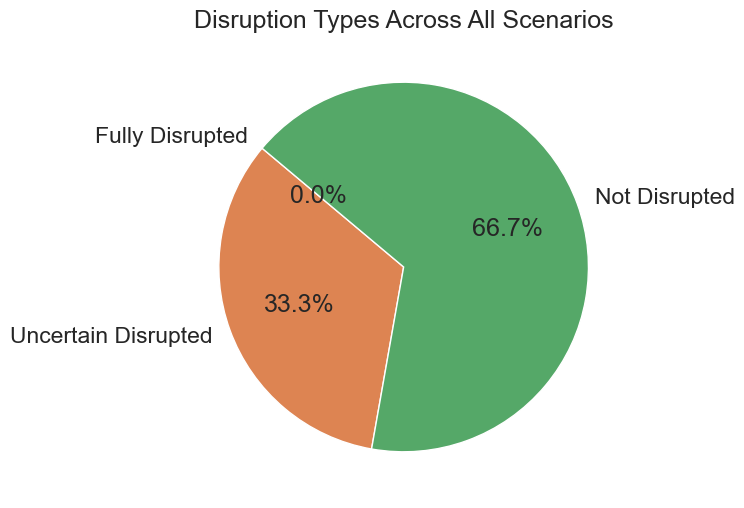

In [17]:
import matplotlib.pyplot as plt

# Data for disruption types
disruption_counts = [
    sum(metrics['num_fully_disrupted'] for metrics in results.values()),
    sum(metrics['num_uncertain_disrupted'] for metrics in results.values()),
    sum(metrics['num_not_disrupted'] for metrics in results.values())
]
disruption_labels = ['Fully Disrupted', 'Uncertain Disrupted', 'Not Disrupted']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(disruption_counts, labels=disruption_labels, autopct='%1.1f%%', startangle=140)
plt.title('Disruption Types Across All Scenarios')
plt.show()


# Probabilities

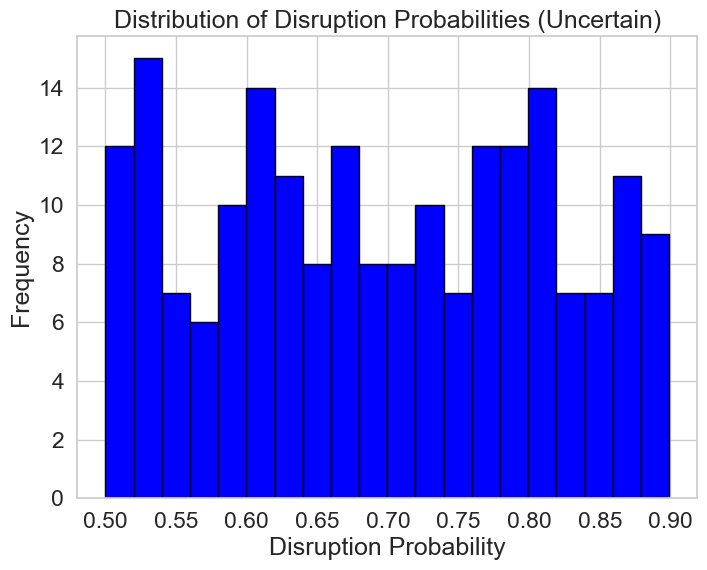

In [18]:
# Plot
plt.figure(figsize=(8, 6))
plt.hist(uncertainties, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Disruption Probabilities (Uncertain)')
plt.xlabel('Disruption Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Length of disrptions

In [19]:
import numpy as np

# For each scenario, calculate the disruption length metrics
for scenario_name, scenario_data in scenarios.items():
    # Initialize dictionaries to store unavailability periods per disruption type
    disruption_lengths = {
        'fully_disrupted': [],
        'uncertain_disrupted': [],
        'not_disrupted': []
    }
    
    # Get the list of disruptions for the current scenario
    disruptions = scenario_data['disruptions']['disruptions']
    
    # Process each disruption
    for disruption in disruptions:
        aircraft_id = disruption['aircraft_id']
        probability = disruption['probability']
        unavailability_period = disruption['unavailability_period_minutes']
        
        # Categorize and collect unavailability periods
        if probability == 1.0:
            disruption_lengths['fully_disrupted'].append(unavailability_period)
        elif 0.0 < probability < 1.0:
            disruption_lengths['uncertain_disrupted'].append(unavailability_period)
        elif probability == 0.0:
            disruption_lengths['not_disrupted'].append(unavailability_period)
        else:
            print(f"Unexpected probability value {probability} for aircraft {aircraft_id} in scenario {scenario_name}")
    
    # # Calculate and print the metrics for each disruption type
    # for disruption_type, lengths in disruption_lengths.items():
    #     if lengths:
    #         mean_length = np.mean(lengths)
    #         median_length = np.median(lengths)
    #         std_dev_length = np.std(lengths)
    #         min_length = np.min(lengths)
    #         max_length = np.max(lengths)
            
    #         print(f"Scenario: {scenario_name} - {disruption_type.replace('_', ' ').title()}")
    #         print(f"Average Length (Mean): {mean_length:.2f} minutes")
    #         print(f"Average Length (Median): {median_length:.2f} minutes")
    #         print(f"Standard Deviation: {std_dev_length:.2f} minutes")
    #         print(f"Minimum Length: {min_length} minutes")
    #         print(f"Maximum Length: {max_length} minutes")
    #         print("\n")
    #     else:
    #         print(f"Scenario: {scenario_name} - {disruption_type.replace('_', ' ').title()}")
    #         print("No disruptions in this category.\n")


# Per disruption type, calculate the average length of the disruptions
# Initialize dictionaries to store all lengths across scenarios
all_disruption_lengths = {
    'fully_disrupted': [],
    'uncertain_disrupted': [],
    'not_disrupted': []
}

# Collect lengths from all scenarios
for scenario_name, scenario_data in scenarios.items():
    disruptions = scenario_data['disruptions']['disruptions']
    
    for disruption in disruptions:
        probability = disruption['probability']
        unavailability_period = disruption['unavailability_period_minutes']
        
        if probability == 1.0:
            all_disruption_lengths['fully_disrupted'].append(unavailability_period)
        elif 0.0 < probability < 1.0:
            all_disruption_lengths['uncertain_disrupted'].append(unavailability_period)
        elif probability == 0.0:
            all_disruption_lengths['not_disrupted'].append(unavailability_period)

# Calculate and print overall statistics for each disruption type
print("Overall Statistics Across All Scenarios:")
print(f"Scenario ID: {id}")
print("-" * 40)
for disruption_type, lengths in all_disruption_lengths.items():
    if lengths:
        mean_length = np.mean(lengths)
        median_length = np.median(lengths)
        std_dev_length = np.std(lengths)
        min_length = np.min(lengths)
        max_length = np.max(lengths)
        
        print(f"\n{disruption_type.replace('_', ' ').title()}:")
        print(f"Number of disruptions: {len(lengths)}")
        print(f"Average Length (Mean): {mean_length:.2f} minutes")
        print(f"Average Length (Median): {median_length:.2f} minutes") 
        print(f"Standard Deviation: {std_dev_length:.2f} minutes")
        print(f"Minimum Length: {min_length} minutes")
        print(f"Maximum Length: {max_length} minutes")
    else:
        print(f"\n{disruption_type.replace('_', ' ').title()}:")
        print("No disruptions in this category.")


Overall Statistics Across All Scenarios:
Scenario ID: 0857
----------------------------------------

Fully Disrupted:
No disruptions in this category.

Uncertain Disrupted:
Number of disruptions: 200
Average Length (Mean): 294.50 minutes
Average Length (Median): 282.00 minutes
Standard Deviation: 104.45 minutes
Minimum Length: 120 minutes
Maximum Length: 478 minutes

Not Disrupted:
No disruptions in this category.


# Start time analysis

In [20]:
# Initialize dictionaries to store start times for all scenarios globally
global_disruption_start_times = {
    'fully_disrupted': [],
    'uncertain_disrupted': [],
    'not_disrupted': []
}

# Aggregate start times from all scenarios
for scenario_name, scenario_data in scenarios.items():
    disruptions = scenario_data['disruptions']['disruptions']
    
    for disruption in disruptions:
        aircraft_id = disruption['aircraft_id']
        probability = disruption['probability']
        start_time = disruption['delta_start_minutes']
        
        # Categorize and collect start times globally
        if probability == 1.0:
            global_disruption_start_times['fully_disrupted'].append(start_time)
        elif 0.0 < probability < 1.0:
            global_disruption_start_times['uncertain_disrupted'].append(start_time)
        elif probability == 0.0:
            global_disruption_start_times['not_disrupted'].append(start_time)
        else:
            print(f"Unexpected probability value {probability} for aircraft {aircraft_id} in scenario {scenario_name}")

# Calculate and print global metrics for each disruption type
for disruption_type, start_times in global_disruption_start_times.items():
    if start_times:
        mean_start_time = np.mean(start_times)
        median_start_time = np.median(start_times)
        std_dev_start_time = np.std(start_times)
        earliest_start_time = np.min(start_times)
        latest_start_time = np.max(start_times)
        
        print(f"Disruption start times - {disruption_type.replace('_', ' ').title()}")
        print(f"Average Start Time (Mean): {mean_start_time:.2f} minutes")
        print(f"Average Start Time (Median): {median_start_time:.2f} minutes")
        print(f"Standard Deviation: {std_dev_start_time:.2f} minutes")
        print(f"Earliest Start Time: {earliest_start_time} minutes")
        print(f"Latest Start Time: {latest_start_time} minutes")
        print("\n")
    else:
        print(f"Disruption start times - {disruption_type.replace('_', ' ').title()}")
        print("No disruptions in this category.\n")


Disruption start times - Fully Disrupted
No disruptions in this category.

Disruption start times - Uncertain Disrupted
Average Start Time (Mean): 303.09 minutes
Average Start Time (Median): 293.00 minutes
Standard Deviation: 109.86 minutes
Earliest Start Time: 121 minutes
Latest Start Time: 479 minutes


Disruption start times - Not Disrupted
No disruptions in this category.



# End time analysis

In [21]:
# Initialize dictionaries to store end times (relative to recovery period start and end) for all scenarios globally
global_disruption_end_times_start_relative = {
    'fully_disrupted': [],
    'uncertain_disrupted': [],
    'not_disrupted': []
}

global_disruption_end_times_end_relative = {
    'fully_disrupted': [],
    'uncertain_disrupted': [],
    'not_disrupted': []
}

# Aggregate end times from all scenarios
for scenario_name, scenario_data in scenarios.items():
    disruptions = scenario_data['disruptions']['disruptions']
    
    for disruption in disruptions:
        aircraft_id = disruption['aircraft_id']
        probability = disruption['probability']
        start_time = disruption['delta_start_minutes']
        unavailability_period = disruption['unavailability_period_minutes']
        
        # Calculate end times
        end_time_start_relative = start_time + unavailability_period
        end_time_end_relative = unavailability_period  # Assuming end relative to recovery period is unavailability period itself
        
        # Categorize and collect end times globally
        if probability == 1.0:
            global_disruption_end_times_start_relative['fully_disrupted'].append(end_time_start_relative)
            global_disruption_end_times_end_relative['fully_disrupted'].append(end_time_end_relative)
        elif 0.0 < probability < 1.0:
            global_disruption_end_times_start_relative['uncertain_disrupted'].append(end_time_start_relative)
            global_disruption_end_times_end_relative['uncertain_disrupted'].append(end_time_end_relative)
        elif probability == 0.0:
            global_disruption_end_times_start_relative['not_disrupted'].append(end_time_start_relative)
            global_disruption_end_times_end_relative['not_disrupted'].append(end_time_end_relative)
        else:
            print(f"Unexpected probability value {probability} for aircraft {aircraft_id} in scenario {scenario_name}")

# Calculate and print global metrics for end times (relative to start and end of recovery period)
for disruption_type in global_disruption_end_times_start_relative.keys():
    # Metrics for end times relative to recovery period start
    end_times_start = global_disruption_end_times_start_relative[disruption_type]
    if end_times_start:
        mean_end_start = np.mean(end_times_start)
        median_end_start = np.median(end_times_start)
        std_dev_end_start = np.std(end_times_start)
        min_end_start = np.min(end_times_start)
        max_end_start = np.max(end_times_start)
        
        print(f"Disruption end times  - {disruption_type.replace('_', ' ').title()} (End Time Relative to Start of Recovery)")
        print(f"Average End Time (Mean): {mean_end_start:.2f} minutes")
        print(f"Median End Time: {median_end_start:.2f} minutes")
        print(f"Standard Deviation: {std_dev_end_start:.2f} minutes")
        print(f"Earliest End Time: {min_end_start} minutes")
        print(f"Latest End Time: {max_end_start} minutes")
        print("\n")
    else:
        print(f"Disruption end times  - {disruption_type.replace('_', ' ').title()} (End Time Relative to Start of Recovery)")
        print("No disruptions in this category.\n")
    
    # Metrics for end times relative to recovery period end
    end_times_end = global_disruption_end_times_end_relative[disruption_type]
    if end_times_end:
        mean_end_end = np.mean(end_times_end)
        median_end_end = np.median(end_times_end)
        std_dev_end_end = np.std(end_times_end)
        min_end_end = np.min(end_times_end)
        max_end_end = np.max(end_times_end)
        
        print(f"Disruption end times  - {disruption_type.replace('_', ' ').title()} (End Time Relative to End of Recovery)")
        print(f"Average End Time (Mean): {mean_end_end:.2f} minutes")
        print(f"Median End Time: {median_end_end:.2f} minutes")
        print(f"Standard Deviation: {std_dev_end_end:.2f} minutes")
        print(f"Earliest End Time: {min_end_end} minutes")
        print(f"Latest End Time: {max_end_end} minutes")
        print("\n")
    else:
        print(f"Disruption end times  - {disruption_type.replace('_', ' ').title()} (End Time Relative to End of Recovery)")
        print("No disruptions in this category.\n")


Disruption end times  - Fully Disrupted (End Time Relative to Start of Recovery)
No disruptions in this category.

Disruption end times  - Fully Disrupted (End Time Relative to End of Recovery)
No disruptions in this category.

Disruption end times  - Uncertain Disrupted (End Time Relative to Start of Recovery)
Average End Time (Mean): 597.59 minutes
Median End Time: 600.50 minutes
Standard Deviation: 161.03 minutes
Earliest End Time: 272 minutes
Latest End Time: 930 minutes


Disruption end times  - Uncertain Disrupted (End Time Relative to End of Recovery)
Average End Time (Mean): 294.50 minutes
Median End Time: 282.00 minutes
Standard Deviation: 104.45 minutes
Earliest End Time: 120 minutes
Latest End Time: 478 minutes


Disruption end times  - Not Disrupted (End Time Relative to Start of Recovery)
No disruptions in this category.

Disruption end times  - Not Disrupted (End Time Relative to End of Recovery)
No disruptions in this category.



# Disruption duration plot

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/3377092997.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(length_data, labels=labels, patch_artist=True)


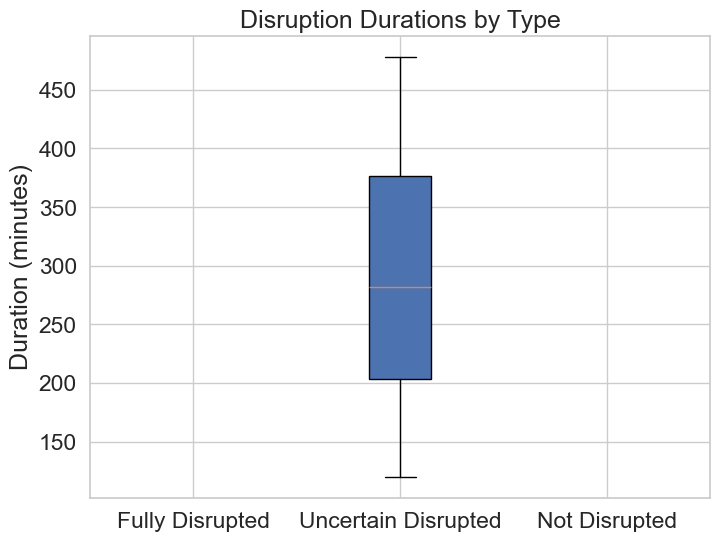

In [22]:
# Data preparation
length_data = [
    all_disruption_lengths['fully_disrupted'],
    all_disruption_lengths['uncertain_disrupted'],
    all_disruption_lengths['not_disrupted']
]
labels = ['Fully Disrupted', 'Uncertain Disrupted', 'Not Disrupted']

# Plot
plt.figure(figsize=(8, 6))
plt.boxplot(length_data, labels=labels, patch_artist=True)
plt.title('Disruption Durations by Type')
plt.ylabel('Duration (minutes)')
plt.grid(True)
plt.show()


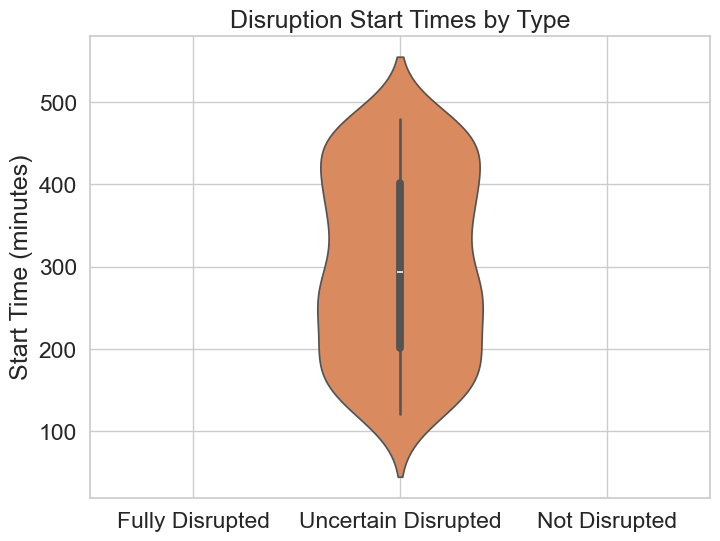

In [23]:
import seaborn as sns

# Data preparation
start_time_data = [
    global_disruption_start_times['fully_disrupted'],
    global_disruption_start_times['uncertain_disrupted'],
    global_disruption_start_times['not_disrupted']
]

# Plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=start_time_data, palette='muted')
plt.xticks(ticks=[0, 1, 2], labels=['Fully Disrupted', 'Uncertain Disrupted', 'Not Disrupted'])
plt.title('Disruption Start Times by Type')
plt.ylabel('Start Time (minutes)')
plt.grid(True)
plt.show()


In [24]:
# Initialize dictionaries to store flight overlap counts globally and per scenario
global_flight_impact_metrics = {
    'fully_disrupted': 0,
    'uncertain_disrupted': 0,
    'not_disrupted': 0
}

# Track per-scenario counts for standard deviation calculation
scenario_flight_counts = {
    'fully_disrupted': [],
    'uncertain_disrupted': [], 
    'not_disrupted': []
}

# Aggregate flight impact metrics from all scenarios
for scenario_name, scenario_data in scenarios.items():
    disruptions = scenario_data['disruptions']['disruptions']
    flights = scenario_data['flights']  # Flights data for the current scenario
    
    # Track counts for this scenario
    scenario_counts = {
        'fully_disrupted': 0,
        'uncertain_disrupted': 0,
        'not_disrupted': 0
    }

    for disruption in disruptions:
        aircraft_id = disruption['aircraft_id']
        probability = disruption['probability']
        disruption_start = disruption['delta_start_minutes']
        disruption_end = disruption_start + disruption['unavailability_period_minutes']

        # Find flights assigned to the disrupted aircraft
        overlapping_flights = 0
        for flight_id, flight_data in flights.items():
            if flight_data['Aircraft'] == aircraft_id:
                # Parse flight departure and arrival times into minutes
                dep_time_parts = [int(x) for x in flight_data['DepTime'].split(":")]
                arr_time_parts = [int(x) for x in flight_data['ArrTime'].split(":")]
                dep_time_minutes = dep_time_parts[0] * 60 + dep_time_parts[1]
                arr_time_minutes = arr_time_parts[0] * 60 + arr_time_parts[1]

                # Check if the flight overlaps with the disruption
                if (dep_time_minutes < disruption_end and arr_time_minutes > disruption_start):
                    overlapping_flights += 1

        # Increment the global and scenario counts based on disruption type
        if probability == 1.0:
            global_flight_impact_metrics['fully_disrupted'] += overlapping_flights
            scenario_counts['fully_disrupted'] += overlapping_flights
        elif 0.0 < probability < 1.0:
            global_flight_impact_metrics['uncertain_disrupted'] += overlapping_flights
            scenario_counts['uncertain_disrupted'] += overlapping_flights
        elif probability == 0.0:
            global_flight_impact_metrics['not_disrupted'] += overlapping_flights
            scenario_counts['not_disrupted'] += overlapping_flights
        else:
            print(f"Unexpected probability value {probability} for aircraft {aircraft_id} in scenario {scenario_name}")
    
    # Add this scenario's counts to the list for standard deviation calculation
    for disruption_type in scenario_counts:
        scenario_flight_counts[disruption_type].append(scenario_counts[disruption_type])

print(f"\nFlights impacted across all scenarios:")
# Print the flight impact metrics globally
for disruption_type in global_flight_impact_metrics:
    total_flights = global_flight_impact_metrics[disruption_type]
    avg_flights = total_flights / total_scenarios
    std_dev = np.std(scenario_flight_counts[disruption_type])
    
    print(f"    {disruption_type.replace('_', ' ').title()}")
    print(f"        Total Flights Overlapping with Disruption: {total_flights}")
    print(f"        Average number of flights overlapping with disruption: {avg_flights:.2f}")
    print(f"        Standard Deviation of overlapping flights: {std_dev:.2f}")
    print(f"        Maximum: {np.max(scenario_flight_counts[disruption_type])} | Minimum: {np.min(scenario_flight_counts[disruption_type])}\n")



Flights impacted across all scenarios:
    Fully Disrupted
        Total Flights Overlapping with Disruption: 0
        Average number of flights overlapping with disruption: 0.00
        Standard Deviation of overlapping flights: 0.00
        Maximum: 0 | Minimum: 0

    Uncertain Disrupted
        Total Flights Overlapping with Disruption: 189
        Average number of flights overlapping with disruption: 1.89
        Standard Deviation of overlapping flights: 1.20
        Maximum: 4 | Minimum: 0

    Not Disrupted
        Total Flights Overlapping with Disruption: 0
        Average number of flights overlapping with disruption: 0.00
        Standard Deviation of overlapping flights: 0.00
        Maximum: 0 | Minimum: 0



# Impact per disruption type

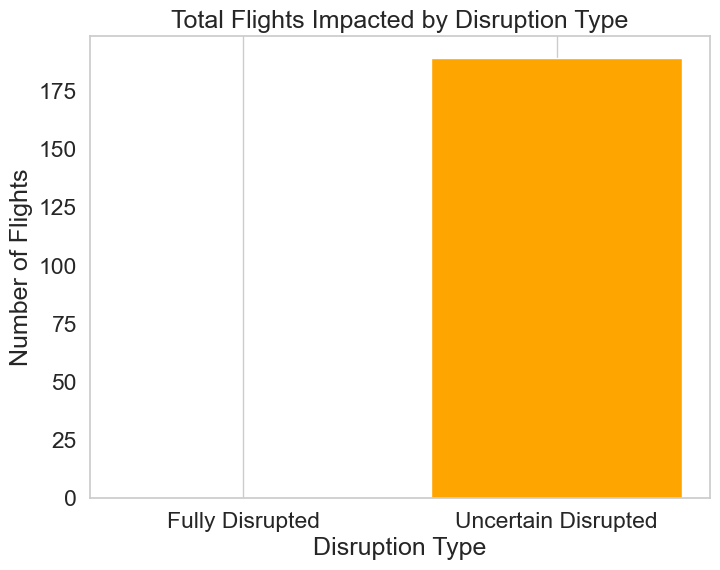

In [25]:
# Data for flight impact
impact_counts = [
    global_flight_impact_metrics['fully_disrupted'],
    global_flight_impact_metrics['uncertain_disrupted']
]
impact_labels = ['Fully Disrupted', 'Uncertain Disrupted']

# Plot
plt.figure(figsize=(8, 6))
plt.bar(impact_labels, impact_counts, color=['red', 'orange'])
plt.title('Total Flights Impacted by Disruption Type')
plt.ylabel('Number of Flights')
plt.xlabel('Disruption Type')
plt.grid(axis='y')
plt.show()


# Swappable options!

In [26]:
def calculate_swapping_possibilities(scenario_data):
    """
    Calculate swapping possibilities for each flight in a given scenario, excluding aircraft with overlapping disruptions.
    """
    flights = scenario_data['flights']
    aircraft_ids = scenario_data['aircraft_ids']

    # Build the aircraft schedule map
    aircraft_schedule = {aircraft: [] for aircraft in aircraft_ids}
    for flight_id, flight_data in flights.items():
        dep_time_minutes = _convert_time_to_minutes(flight_data['DepTime'])
        arr_time_minutes = _convert_time_to_minutes(flight_data['ArrTime'])
        aircraft_schedule[flight_data['Aircraft']].append((dep_time_minutes, arr_time_minutes))

    # Build the disruption schedule map
    disruptions = scenario_data['disruptions']['disruptions']
    aircraft_disruptions = {aircraft: [] for aircraft in aircraft_ids}
    for d in disruptions:
        # Convert disruption start/end times to minutes
        start_mins = _convert_time_to_minutes(d['start_time'])
        end_mins = _convert_time_to_minutes(d['end_time'])

        # If the disruption crosses midnight and goes into the next day, handle accordingly
        # Here we assume the data either does not cross days or is handled externally.
        # If needed, add logic for day offsets. For now, we assume same-day or pre-processed times.
        
        aircraft_disruptions[d['aircraft_id']].append((start_mins, end_mins))

    # Initialize the swapping options dictionary
    swapping_options = {}

    # Loop through each aircraft and its flights
    for aircraft_id, schedule in aircraft_schedule.items():
        for flight_id, flight_data in flights.items():
            if flight_data['Aircraft'] != aircraft_id:
                continue

            # Get the flight times
            dep_time_minutes = _convert_time_to_minutes(flight_data['DepTime'])
            arr_time_minutes = _convert_time_to_minutes(flight_data['ArrTime'])

            # Calculate swapping options for this flight
            swappable_count = 0
            for other_aircraft, other_schedule in aircraft_schedule.items():
                if other_aircraft == aircraft_id:
                    continue  # Skip the same aircraft

                # Check if other aircraft is free during the flight's duration
                is_free = all(
                    arr_time_minutes <= other_flight[0] or dep_time_minutes >= other_flight[1]
                    for other_flight in other_schedule
                )

                # Check if other aircraft has no disruption overlapping the flight time
                # Overlapping means: (disruption starts before flight ends) AND (disruption ends after flight starts)
                has_disruption_overlap = any(
                    not (end_mins <= dep_time_minutes or start_mins >= arr_time_minutes)
                    for (start_mins, end_mins) in aircraft_disruptions[other_aircraft]
                )

                if is_free and not has_disruption_overlap:
                    swappable_count += 1

            # Store the result for the flight
            swapping_options[flight_id] = swappable_count

    return swapping_options

def filter_swappable_options(scenario_data, swapping_options):
    """
    Filter flights to include only those that are actually overlapping with a disruption.
    """
    disruptions = scenario_data['disruptions']['disruptions']
    flights = scenario_data['flights']

    # Build a dictionary of disruptions by aircraft_id
    aircraft_disruptions = {}
    for d in disruptions:
        aircraft_id = d['aircraft_id']
        start_mins = _convert_time_to_minutes(d['start_time'])
        end_mins = _convert_time_to_minutes(d['end_time'])
        aircraft_disruptions.setdefault(aircraft_id, []).append((start_mins, end_mins))

    filtered_options = {}

    # Check each flight for disruption overlap
    for flight_id, options in swapping_options.items():
        flight = flights[flight_id]
        aircraft_id = flight['Aircraft']

        dep_mins = _convert_time_to_minutes(flight['DepTime'])
        arr_mins = _convert_time_to_minutes(flight['ArrTime'])

        # Verify if this flight overlaps with any disruption on its assigned aircraft
        if aircraft_id in aircraft_disruptions:
            # Overlap condition: not completely outside each other
            # Flight overlaps disruption if (flight_dep < disruption_end) AND (flight_arr > disruption_start)
            has_overlap = any(
                not (end <= dep_mins or start >= arr_mins)
                for (start, end) in aircraft_disruptions[aircraft_id]
            )

            if has_overlap:
                filtered_options[flight_id] = options

    return filtered_options



def analyze_swappable_options(filtered_options):
    """
    Perform statistical analysis on filtered swappable options.
    """
    if not filtered_options:
        print("No flights with disruptions.")
        return

    values = list(filtered_options.values())
    print("Filtered Swappable Options Analysis:")
    print(f"Mean: {np.mean(values):.2f}")
    print(f"Median: {np.median(values):.2f}")
    print(f"Standard Deviation: {np.std(values):.2f}")
    print(f"Minimum: {np.min(values)}")
    print(f"Maximum: {np.max(values)}")


def _convert_time_to_minutes(time_str):
    """
    Convert time in HH:MM format to minutes since midnight.
    """
    hours, minutes = map(int, time_str.split(":"))
    return hours * 60 + minutes


# Example usage
chosen_scenario_name = "Scenario_27"  # Replace with the desired scenario name
if chosen_scenario_name in scenarios:
    scenario_data = scenarios[chosen_scenario_name]
    swapping_options = calculate_swapping_possibilities(scenario_data)
    filtered_options = filter_swappable_options(scenario_data, swapping_options)
    analyze_swappable_options(filtered_options)
else:
    print(f"Scenario '{chosen_scenario_name}' not found.")


Filtered Swappable Options Analysis:
Mean: 1.00
Median: 1.00
Standard Deviation: 0.00
Minimum: 1
Maximum: 1


# Only for disrupted flights

Statistics per scenario:
   scenario_name      mean  median       std  min  max
0    Scenario_01  1.000000     1.0  0.000000    1    1
1    Scenario_02  1.000000     1.0  0.000000    1    1
2    Scenario_03  1.333333     1.0  0.577350    1    2
3    Scenario_04  1.000000     1.0  1.414214    0    2
4    Scenario_05  1.000000     1.0  0.000000    1    1
..           ...       ...     ...       ...  ...  ...
95   Scenario_95  1.000000     1.0  0.000000    1    1
96   Scenario_96  1.000000     1.0  0.000000    1    1
97   Scenario_97  0.000000     0.0       NaN    0    0
98   Scenario_98  1.000000     1.0  0.000000    1    1
99   Scenario_99  0.000000     0.0  0.000000    0    0

[100 rows x 6 columns]

Overall statistics across all scenarios:
mean      0.886297
median    1.000000
std       0.344402
min       0.000000
max       2.000000
Name: swappable_count, dtype: float64


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette)
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:48: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette)


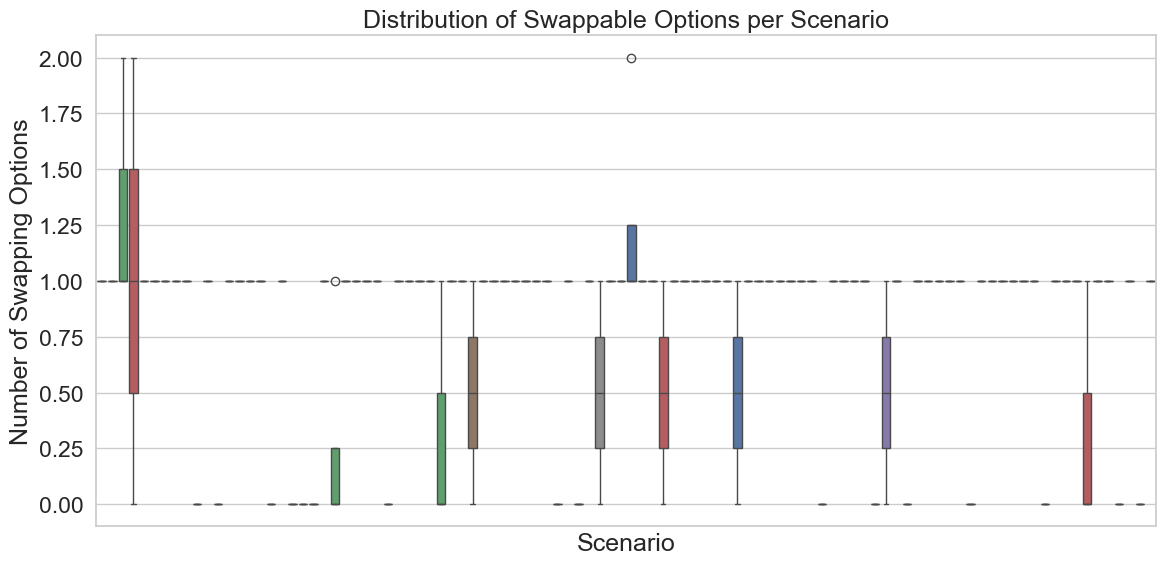

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette, inner="quartile")
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:59: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette, inner="quartile")


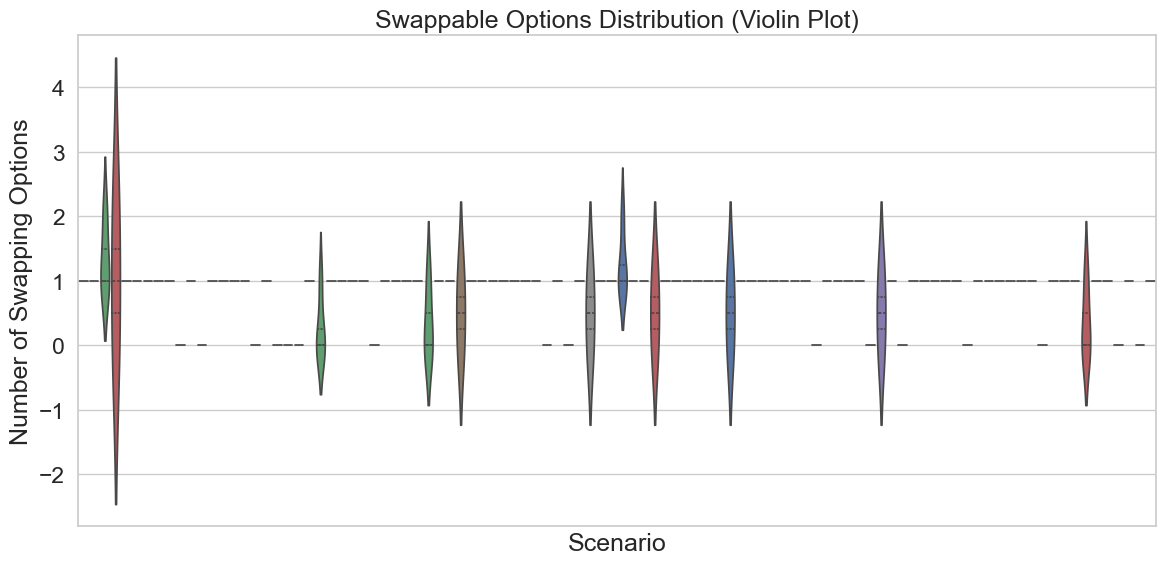

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:72: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=all_data, x='scenario_name', y='swappable_count', ci='sd', palette=palette, capsize=.2)
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_data, x='scenario_name', y='swappable_count', ci='sd', palette=palette, capsize=.2)
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:72: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=all_data, x='scenario_name', y='swappable_count', ci='sd', palette=palette, capsize=.2)


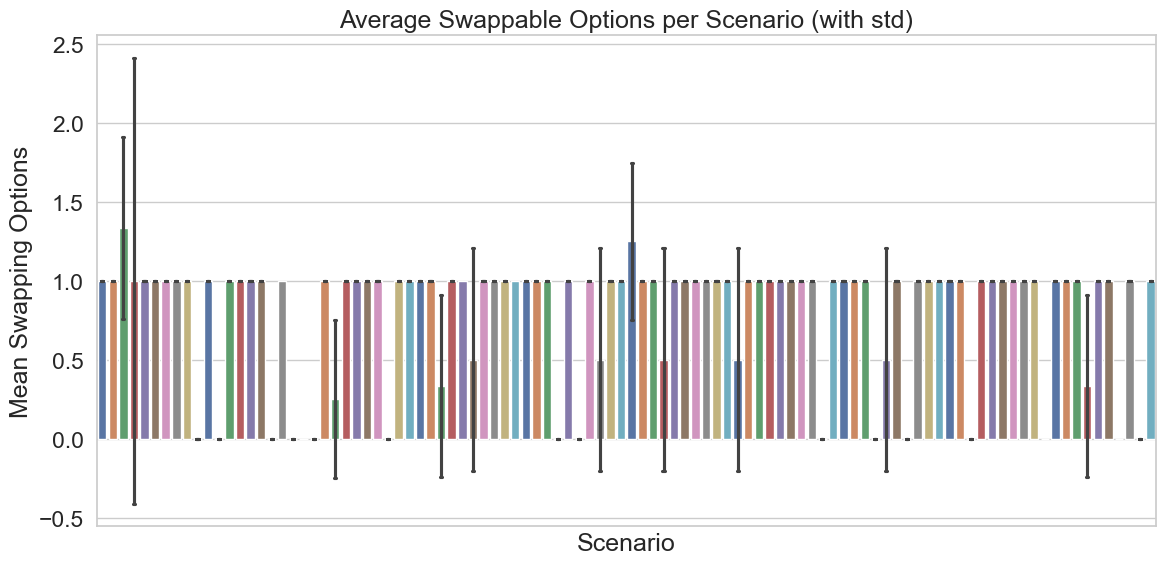

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:83: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=all_data, x='swappable_count', hue='scenario_name', kde=True, palette=palette)
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/1195840335.py:87: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


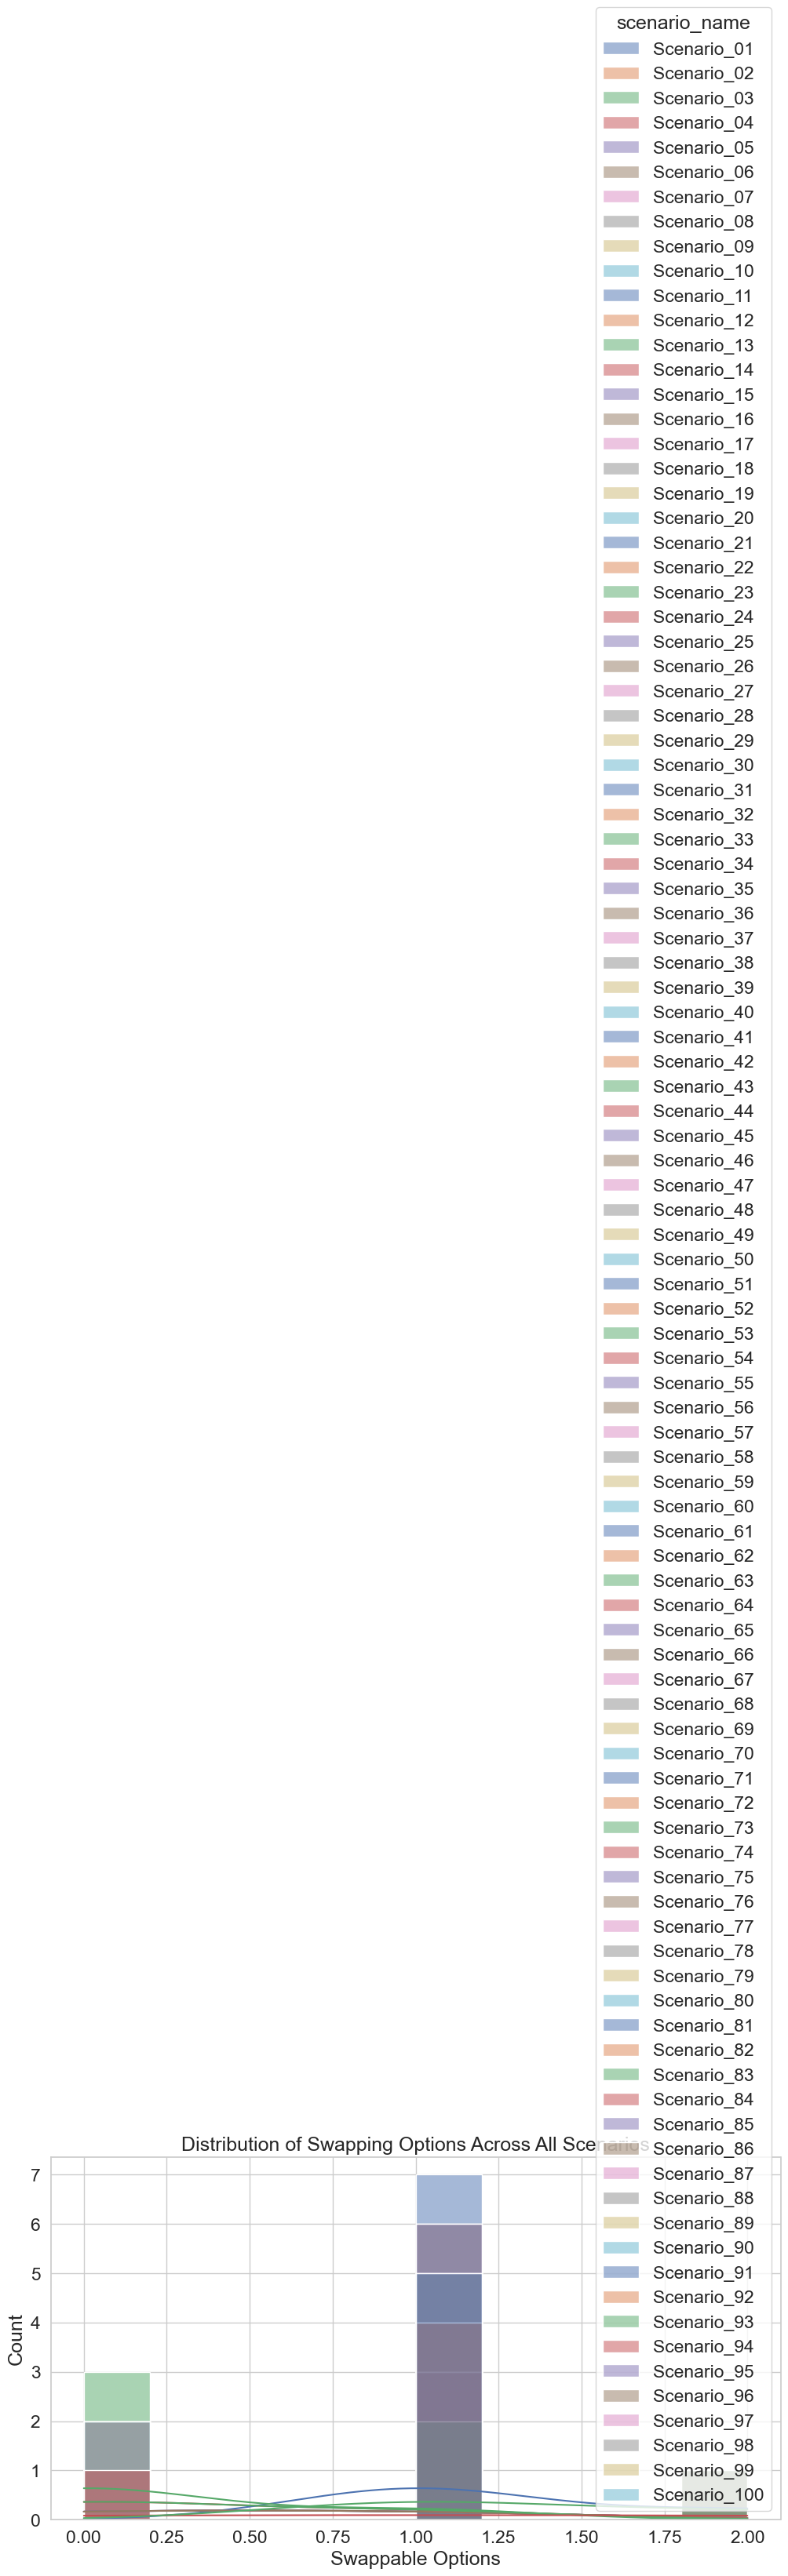

In [27]:
# Run this code locally in your Python environment (in the same folder as the scenario code).
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = []

for scenario_name, scenario_data in scenarios.items():
    swapping_options = calculate_swapping_possibilities(scenario_data)
    filtered_options = filter_swappable_options(scenario_data, swapping_options)
    
    # Convert filtered_options (dict: flight_id -> swappable_count) into a DataFrame
    scenario_df = pd.DataFrame({
        'flight_id': list(filtered_options.keys()),
        'swappable_count': list(filtered_options.values())
    })
    scenario_df['scenario_name'] = scenario_name
    results.append(scenario_df)

# Combine all scenarios into one DataFrame
all_data = pd.concat(results, ignore_index=True)

# Perform statistical analysis per scenario
stats_per_scenario = all_data.groupby('scenario_name')['swappable_count'].agg(
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max'
).reset_index()

print("Statistics per scenario:")
print(stats_per_scenario)

# Overall statistics
overall_stats = all_data['swappable_count'].agg(['mean','median','std','min','max'])
print("\nOverall statistics across all scenarios:")
print(overall_stats)

# Set a nice style for plots
sns.set(style="whitegrid", font_scale=1.5)
palette = sns.color_palette("deep")

# EXAMPLE PLOTS:
# 1. Boxplot of swappable options distribution per scenario
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette)
plt.title("Distribution of Swappable Options per Scenario")
plt.xlabel("Scenario")
plt.ylabel("Number of Swapping Options")
plt.xticks([])  # Remove x-ticks
plt.tight_layout()
plt.savefig("swappable_options_boxplot.png", dpi=300)
plt.show()

# 2. Violin plot for a more detailed distribution
plt.figure(figsize=(12,6))
sns.violinplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette, inner="quartile")
plt.title("Swappable Options Distribution (Violin Plot)")
plt.xlabel("Scenario")
plt.ylabel("Number of Swapping Options")
plt.xticks([])  # Remove x-ticks
plt.tight_layout()
plt.savefig("swappable_options_violinplot.png", dpi=300)
plt.show()

# 3. Bar plot showing mean swappable options per scenario with error bars (std)
# Run this code locally in your Python environment.
plt.figure(figsize=(12,6))
# If you plot directly from all_data (raw data), seaborn can compute the mean and std itself.
sns.barplot(data=all_data, x='scenario_name', y='swappable_count', ci='sd', palette=palette, capsize=.2)
plt.title("Average Swappable Options per Scenario (with std)")
plt.xlabel("Scenario")
plt.ylabel("Mean Swapping Options")
plt.xticks([])  # Remove x-ticks
plt.tight_layout()
plt.show()


# 4. Histogram (or KDE) of all swappable counts combined, colored by scenario
plt.figure(figsize=(12,6))
sns.histplot(data=all_data, x='swappable_count', hue='scenario_name', kde=True, palette=palette)
plt.title("Distribution of Swapping Options Across All Scenarios")
plt.xlabel("Swappable Options")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("swappable_options_histogram.png", dpi=300)
plt.show()

Statistics per scenario:
   scenario_name      mean  median       std  min  max
0    Scenario_01  1.166667     1.0  0.383482    1    2
1    Scenario_02  1.000000     1.0  0.000000    1    1
2    Scenario_03  1.230769     1.0  0.438529    1    2
3    Scenario_04  0.571429     0.5  0.646206    0    2
4    Scenario_05  1.000000     1.0  0.000000    1    1
..           ...       ...     ...       ...  ...  ...
95   Scenario_95  1.142857     1.0  0.534522    1    3
96   Scenario_96  1.105263     1.0  0.458831    1    3
97   Scenario_97  0.090909     0.0  0.301511    0    1
98   Scenario_98  1.055556     1.0  0.235702    1    2
99   Scenario_99  0.473684     0.0  0.964274    0    3

[100 rows x 6 columns]

Overall statistics across all scenarios:
mean      0.866583
median    1.000000
std       0.499190
min       0.000000
max       4.000000
Name: swappable_count, dtype: float64


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette)
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:47: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette)


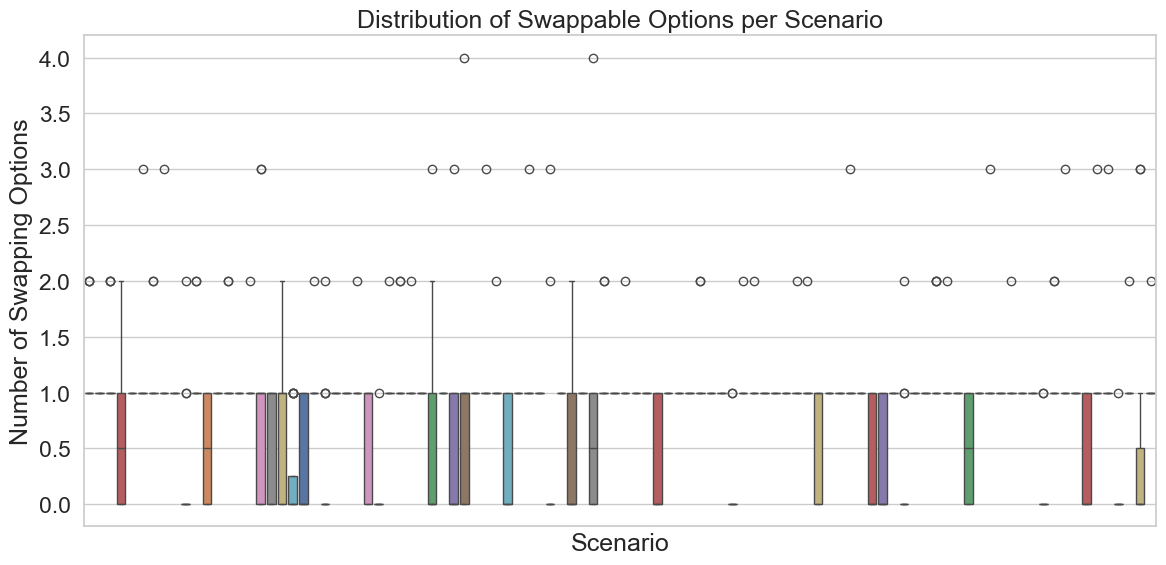

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette, inner="quartile")
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:58: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette, inner="quartile")


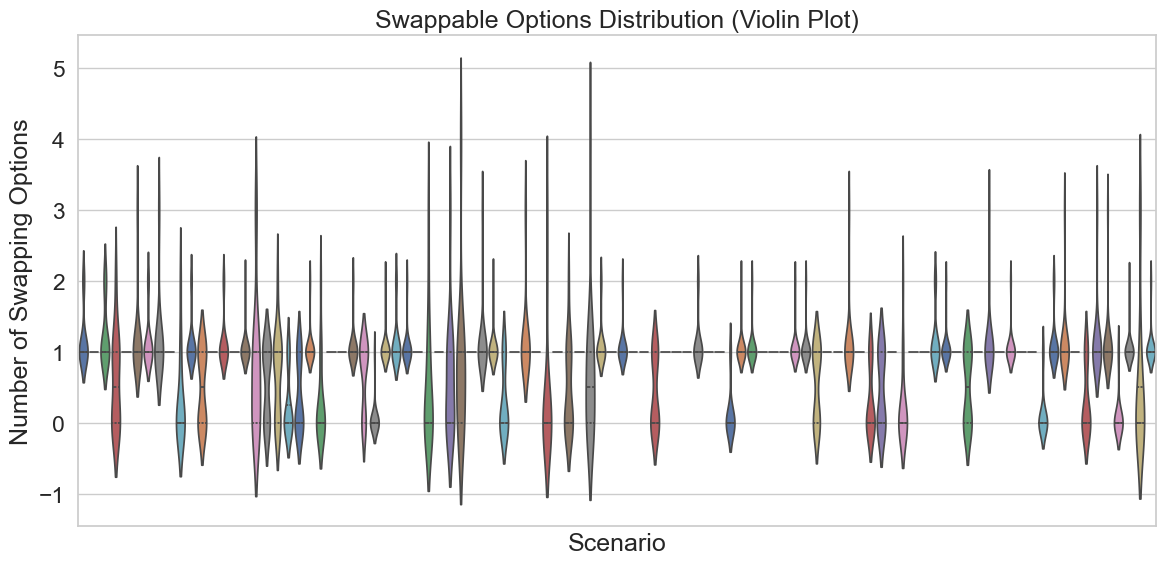

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:70: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=all_data, x='scenario_name', y='swappable_count', ci='sd', palette=palette, capsize=.2)
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_data, x='scenario_name', y='swappable_count', ci='sd', palette=palette, capsize=.2)
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:70: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=all_data, x='scenario_name', y='swappable_count', ci='sd', palette=palette, capsize=.2)


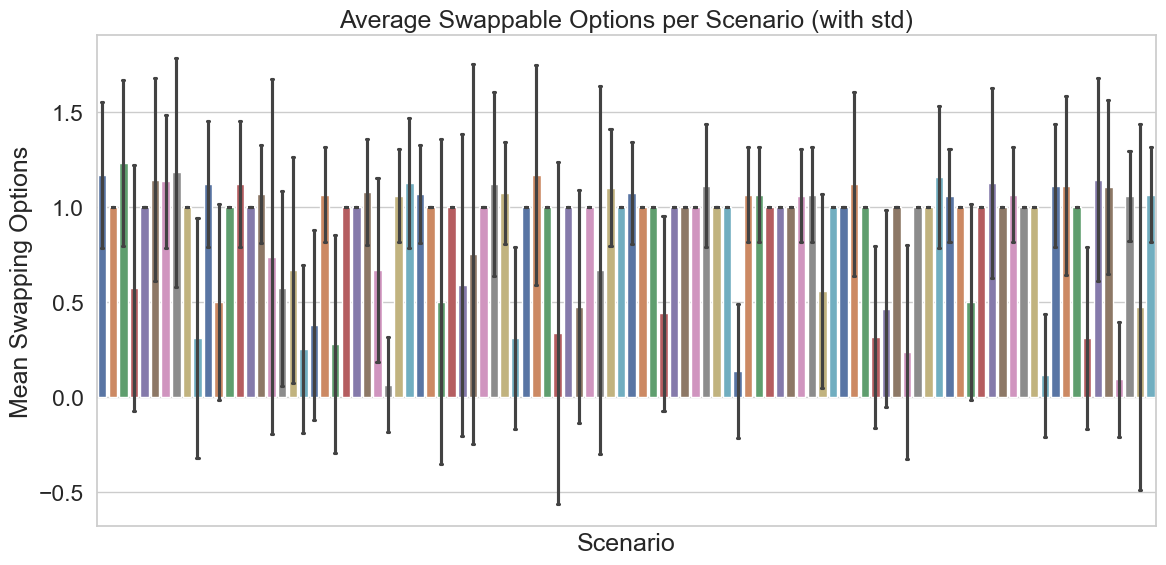

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:80: UserWarning: 
The palette list has fewer values (10) than needed (100) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=all_data, x='swappable_count', hue='scenario_name', kde=True, palette=palette)
/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_24500/2668115956.py:84: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


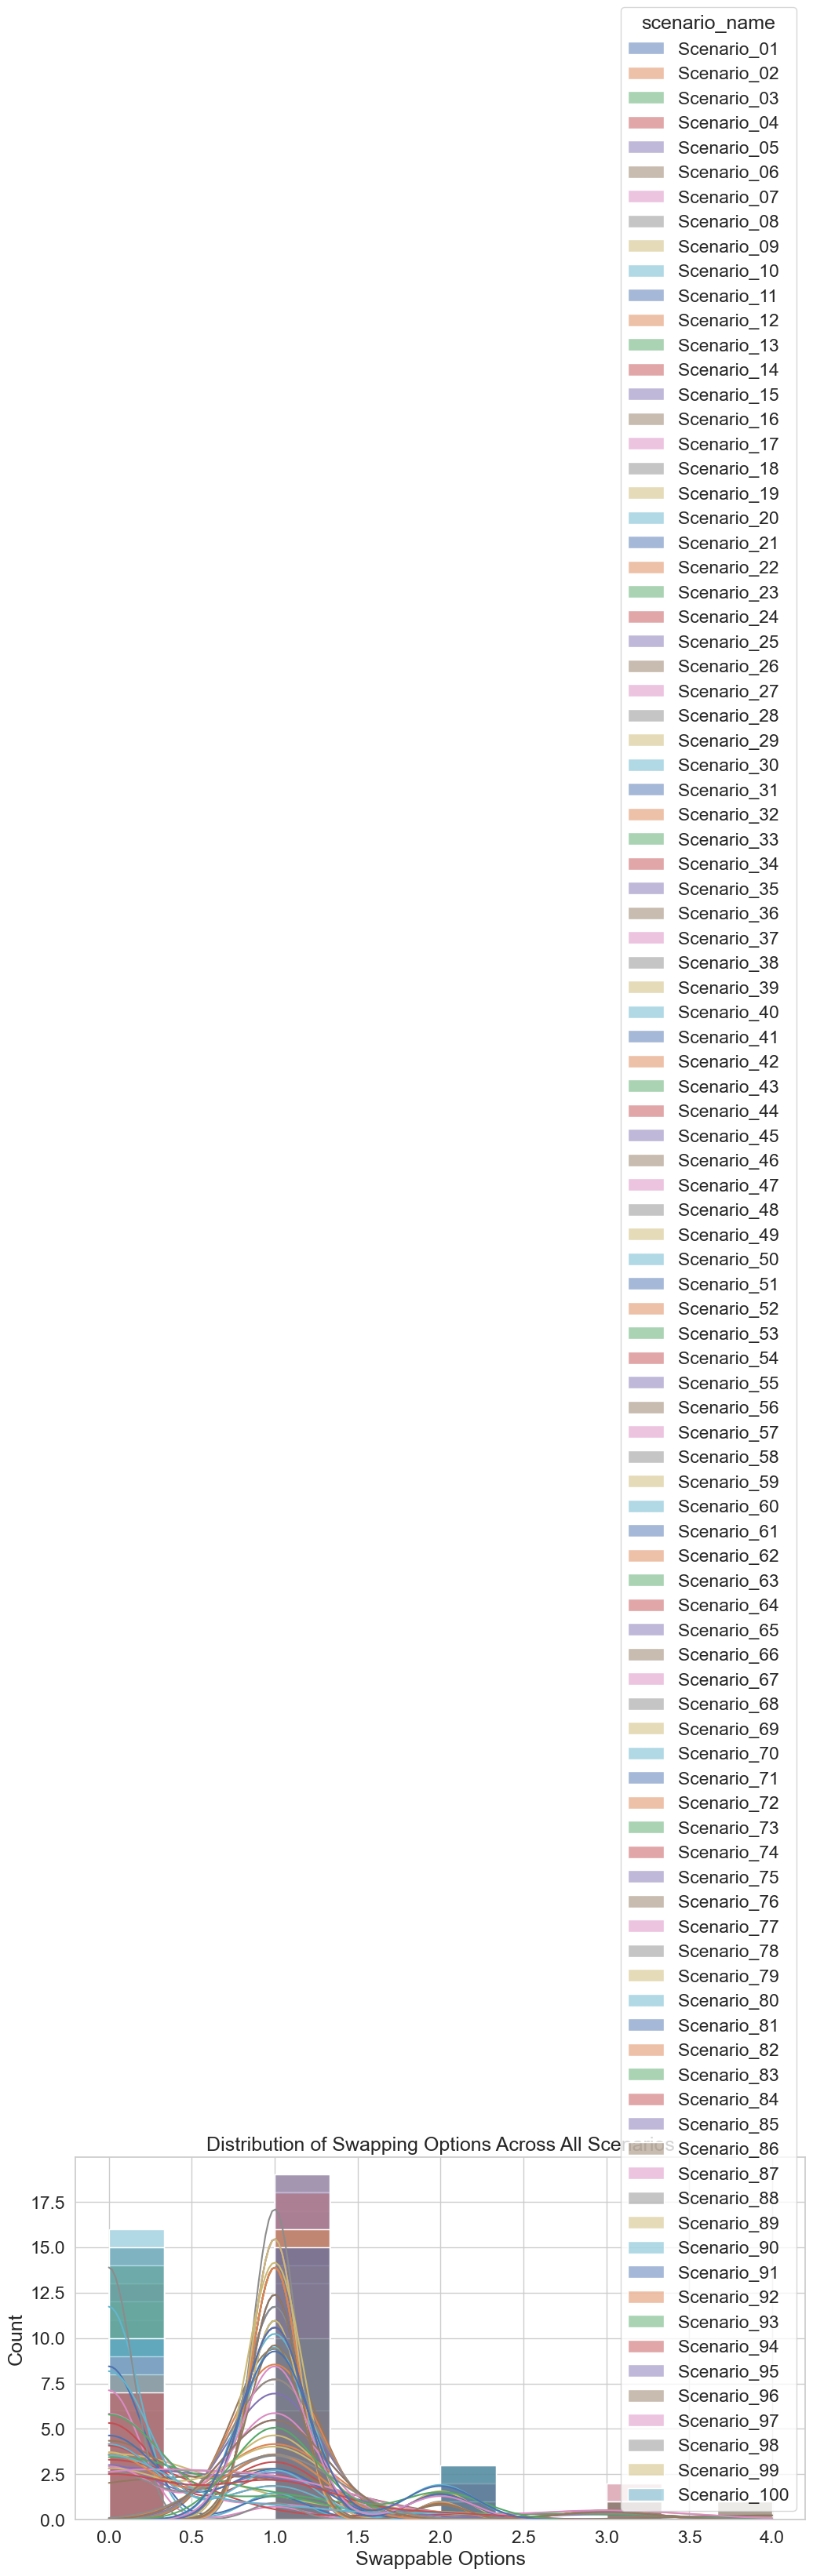

In [28]:
# Run this code locally in your Python environment (in the same folder as the scenario code).
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = []

for scenario_name, scenario_data in scenarios.items():
    swapping_options = calculate_swapping_possibilities(scenario_data)
    # We do NOT filter by disruption overlap now; we take all flights directly from swapping_options.
    
    # Convert swapping_options (dict: flight_id -> swappable_count) into a DataFrame
    scenario_df = pd.DataFrame({
        'flight_id': list(swapping_options.keys()),
        'swappable_count': list(swapping_options.values())
    })
    scenario_df['scenario_name'] = scenario_name
    results.append(scenario_df)

# Combine all scenarios into one DataFrame
all_data = pd.concat(results, ignore_index=True)

# Perform statistical analysis per scenario
stats_per_scenario = all_data.groupby('scenario_name')['swappable_count'].agg(
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max'
).reset_index()

print("Statistics per scenario:")
print(stats_per_scenario)

# Overall statistics
overall_stats = all_data['swappable_count'].agg(['mean','median','std','min','max'])
print("\nOverall statistics across all scenarios:")
print(overall_stats)

# Set a nice style for plots
sns.set(style="whitegrid", font_scale=1.5)
palette = sns.color_palette("deep")

# 1. Boxplot of swappable options distribution per scenario
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette)
plt.title("Distribution of Swappable Options per Scenario")
plt.xlabel("Scenario")
plt.ylabel("Number of Swapping Options")
plt.xticks([])  # Remove x-ticks if desired
plt.tight_layout()
plt.savefig("swappable_options_boxplot.png", dpi=300)
plt.show()

# 2. Violin plot for a more detailed distribution
plt.figure(figsize=(12,6))
sns.violinplot(data=all_data, x='scenario_name', y='swappable_count', palette=palette, inner="quartile")
plt.title("Swappable Options Distribution (Violin Plot)")
plt.xlabel("Scenario")
plt.ylabel("Number of Swapping Options")
plt.xticks([])  # Remove x-ticks if desired
plt.tight_layout()
plt.savefig("swappable_options_violinplot.png", dpi=300)
plt.show()

# 3. Bar plot showing mean swappable options per scenario with error bars (std)
plt.figure(figsize=(12,6))
# Rely on Seaborn's built-in CI to show standard deviation
sns.barplot(data=all_data, x='scenario_name', y='swappable_count', ci='sd', palette=palette, capsize=.2)
plt.title("Average Swappable Options per Scenario (with std)")
plt.xlabel("Scenario")
plt.ylabel("Mean Swapping Options")
plt.xticks([])  # Remove x-ticks if desired
plt.tight_layout()
plt.show()

# 4. Histogram (or KDE) of all swappable counts combined, colored by scenario
plt.figure(figsize=(12,6))
sns.histplot(data=all_data, x='swappable_count', hue='scenario_name', kde=True, palette=palette)
plt.title("Distribution of Swapping Options Across All Scenarios")
plt.xlabel("Swappable Options")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("swappable_options_histogram.png", dpi=300)
plt.show()


Overall statistics across all scenarios combined:
mean      0.866583
median    1.000000
std       0.499190
min       0.000000
max       4.000000
Name: swappable_count, dtype: float64


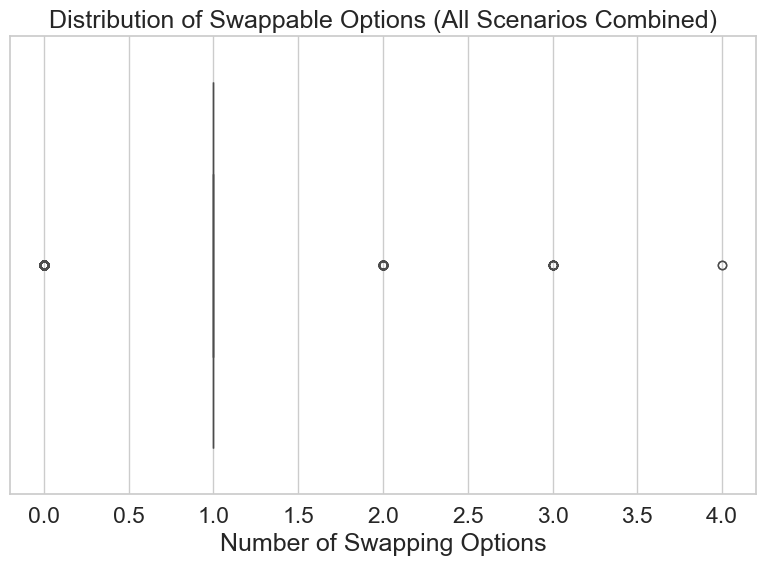

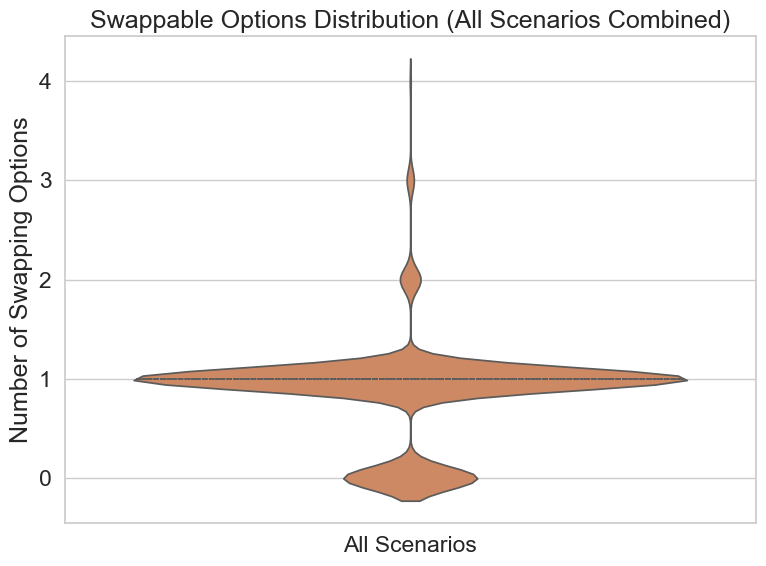

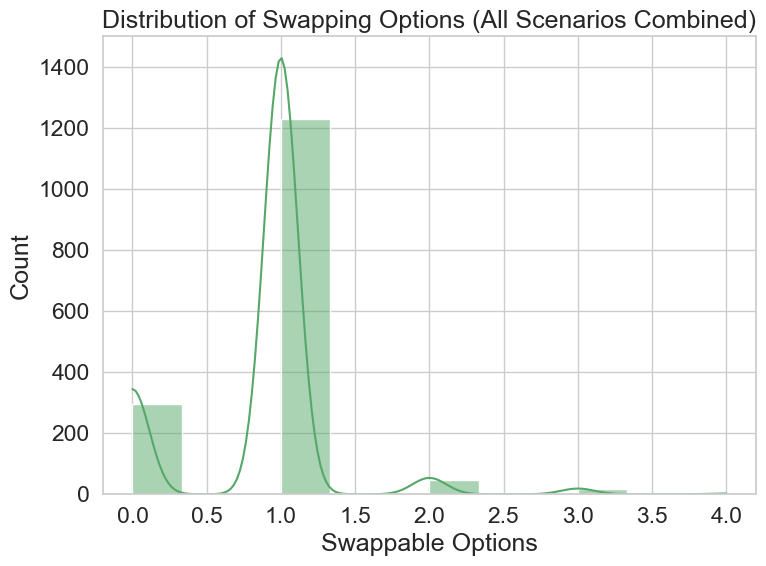

In [29]:
# Run this code locally in your Python environment (in the same folder as the scenario code).
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_flights_data = []

for scenario_name, scenario_data in scenarios.items():
    swapping_options = calculate_swapping_possibilities(scenario_data)
    # Using all flights, no filtering
    scenario_df = pd.DataFrame({
        'flight_id': list(swapping_options.keys()),
        'swappable_count': list(swapping_options.values())
    })
    # We no longer store scenario_name since we are aggregating everything together
    all_flights_data.append(scenario_df)

# Combine all scenario data
all_data = pd.concat(all_flights_data, ignore_index=True)

# Compute overall statistics (no scenario grouping)
overall_stats = all_data['swappable_count'].agg(['mean', 'median', 'std', 'min', 'max'])
print("Overall statistics across all scenarios combined:")
print(overall_stats)

# Set a nice style for plots
sns.set(style="whitegrid", font_scale=1.5)
palette = sns.color_palette("deep")

# Boxplot of the entire dataset
plt.figure(figsize=(8, 6))
sns.boxplot(x=all_data['swappable_count'], color=palette[0])
plt.title("Distribution of Swappable Options (All Scenarios Combined)")
plt.xlabel("Number of Swapping Options")
plt.tight_layout()
plt.savefig("swappable_options_all_scenarios_boxplot.png", dpi=300)
plt.show()

# Violin plot (all scenarios combined as one distribution)
# We'll need a dummy column to allow seaborn to plot a single category
all_data['dummy_category'] = 'All Scenarios'
plt.figure(figsize=(8,6))
sns.violinplot(data=all_data, x='dummy_category', y='swappable_count', color=palette[1], inner="quartile")
plt.title("Swappable Options Distribution (All Scenarios Combined)")
plt.xlabel("")
plt.ylabel("Number of Swapping Options")
plt.tight_layout()
plt.savefig("swappable_options_all_scenarios_violinplot.png", dpi=300)
plt.show()

# Histogram/KDE combined for all scenarios
plt.figure(figsize=(8,6))
sns.histplot(data=all_data, x='swappable_count', kde=True, color=palette[2])
plt.title("Distribution of Swapping Options (All Scenarios Combined)")
plt.xlabel("Swappable Options")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("swappable_options_all_scenarios_histogram.png", dpi=300)
plt.show()


Overall Flight Statistics Across All Scenarios:
Number of scenarios: 100
Total flights across all scenarios: 1589
Average flights per scenario: 15.89
Median flights per scenario: 16.00
Std. dev of flights per scenario: 2.02


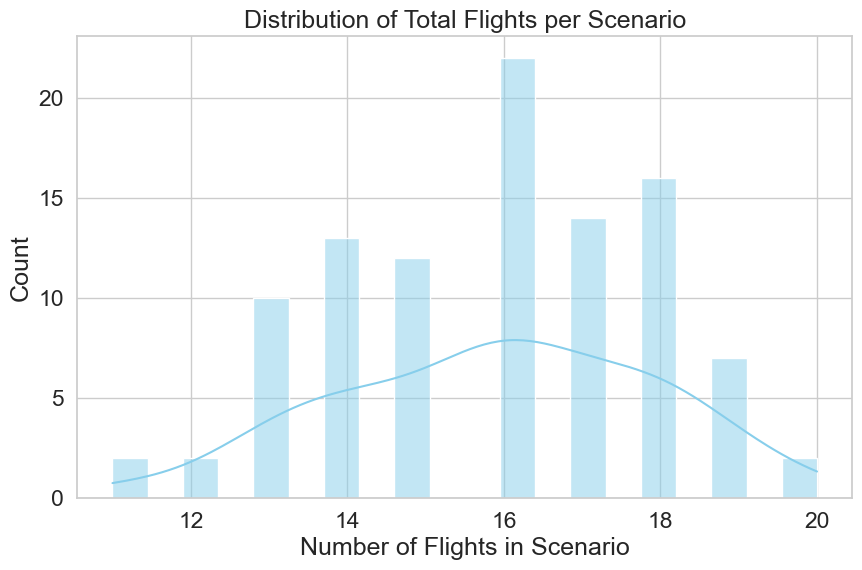


Aircraft Flight Count Statistics Across All Scenarios:
count    600.000000
mean       2.648333
std        1.319431
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: flights, dtype: float64


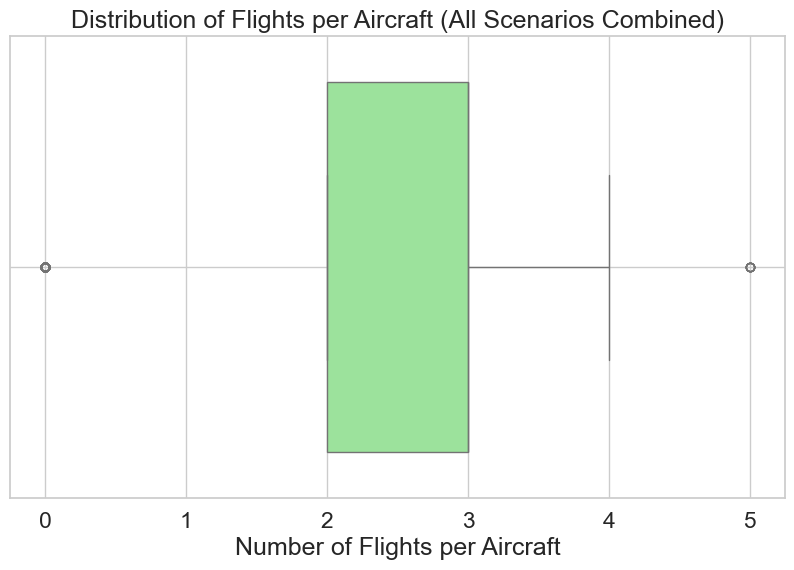

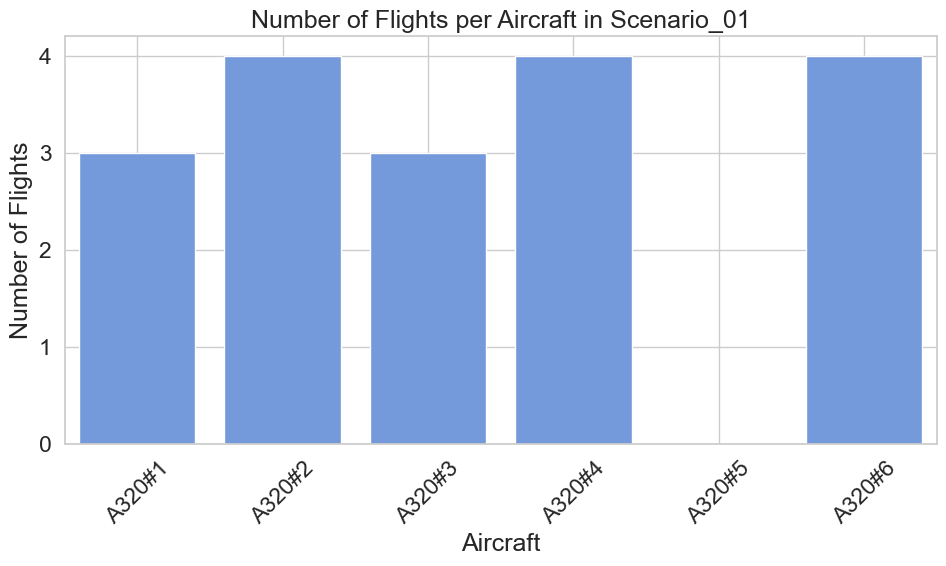


Top 10 Origins Across All Scenarios:
origin
FRA    126
AMS    119
ZRH    118
CPH    118
BRU    118
ORY    110
VIE    106
MUC    105
DUB    101
IST    100
Name: count, dtype: int64

Top 10 Destinations Across All Scenarios:
destination
BRU    122
ZRH    115
MUC    115
ORY    113
FRA    112
MAD    107
CDG    106
LHR    103
DUB    101
VIE    101
Name: count, dtype: int64


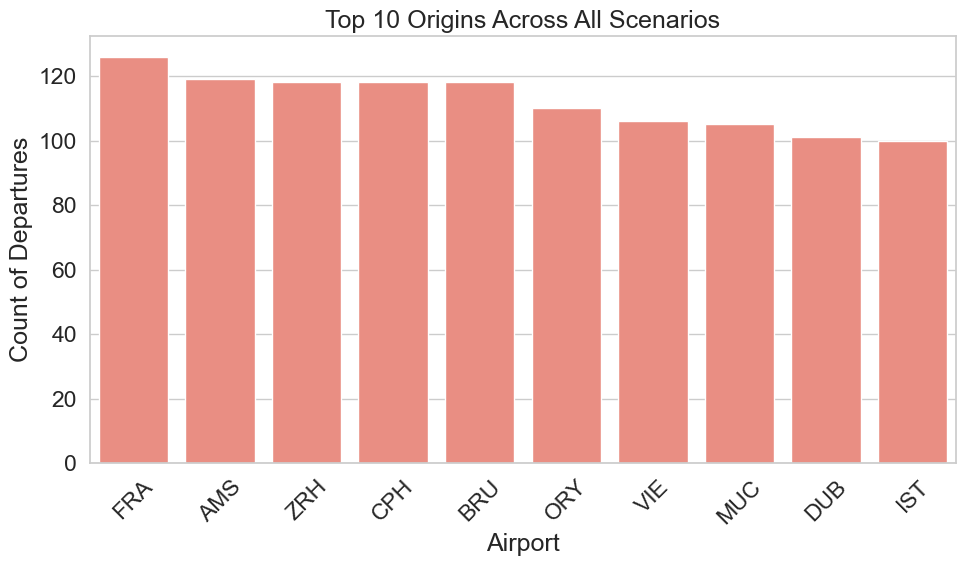

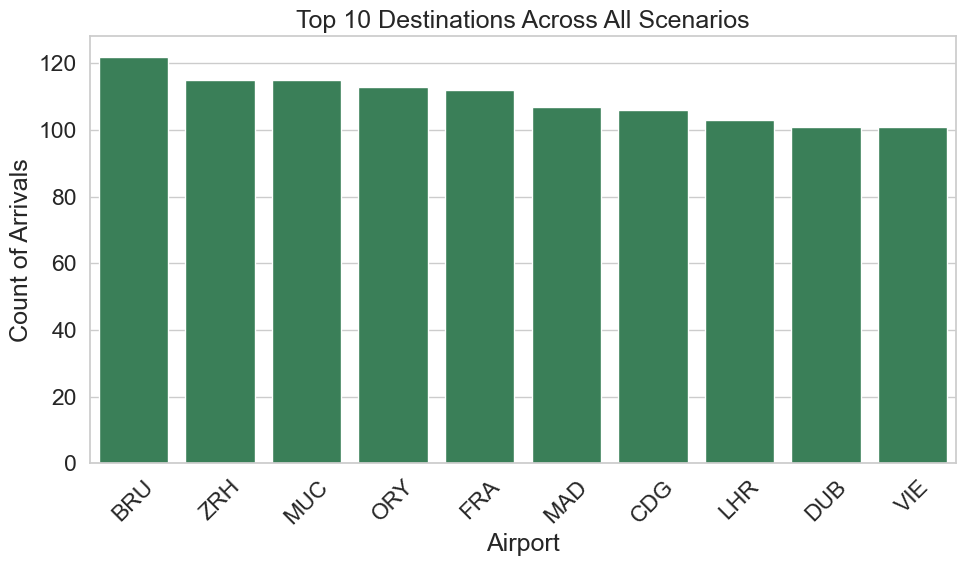

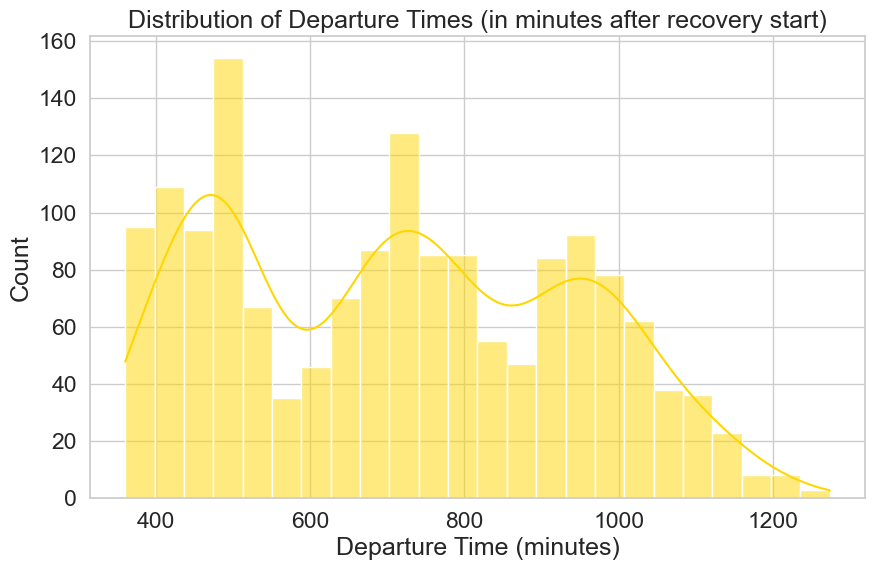


Flight Time Analysis:
Earliest departure: 360 minutes
Latest departure: 1274 minutes
Mean departure time: 714.66 minutes
Median departure time: 713.00 minutes


In [34]:
# %% [markdown]
# # Flight Volume and Distribution Analysis

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Aggregate flight information across all scenarios
all_flights_data = []
scenario_flight_counts = []
aircraft_flight_counts = {}

for scenario_name, scenario_data in scenarios.items():
    # Extract total flights in the scenario
    total_flights = scenario_data['total_flights']
    scenario_flight_counts.append(total_flights)
    
    # Extract flights per aircraft in the scenario
    flights_per_ac = scenario_data['flights_per_aircraft']
    for ac_id, count in flights_per_ac.items():
        aircraft_flight_counts.setdefault(ac_id, []).append(count)
        
    # Create a DataFrame of flights in this scenario
    # flight_id, Orig, Dest, DepTime, ArrTime, Aircraft
    scenario_flights = scenario_data['flights']
    scenario_df = pd.DataFrame([
        {
            'scenario': scenario_name,
            'flight_id': fid,
            'origin': fdata['Orig'],
            'destination': fdata['Dest'],
            'dep_time': fdata['DepTime'],
            'arr_time': fdata['ArrTime'],
            'aircraft': fdata['Aircraft']
        } for fid, fdata in scenario_flights.items()
    ])
    all_flights_data.append(scenario_df)

# Combine all flights data into a single DataFrame
all_flights_df = pd.concat(all_flights_data, ignore_index=True)

# Overall statistics of flights across all scenarios
print("Overall Flight Statistics Across All Scenarios:")
print(f"Number of scenarios: {len(scenarios)}")
print(f"Total flights across all scenarios: {all_flights_df.shape[0]}")
print(f"Average flights per scenario: {np.mean(scenario_flight_counts):.2f}")
print(f"Median flights per scenario: {np.median(scenario_flight_counts):.2f}")
print(f"Std. dev of flights per scenario: {np.std(scenario_flight_counts):.2f}")

# Distribution of flights per scenario (Histogram)
plt.figure(figsize=(10,6))
sns.histplot(scenario_flight_counts, bins=20, color='skyblue', kde=True)
plt.title("Distribution of Total Flights per Scenario")
plt.xlabel("Number of Flights in Scenario")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Analyze flights per aircraft across all scenarios combined
# Flatten the aircraft_flight_counts dictionary into a DataFrame
aircraft_flight_counts_df = pd.DataFrame([
    {'aircraft': ac, 'flights': f} 
    for ac, counts in aircraft_flight_counts.items() 
    for f in counts
])

# Summary statistics for aircraft flights
print("\nAircraft Flight Count Statistics Across All Scenarios:")
print(aircraft_flight_counts_df['flights'].describe())

# Distribution of flights per aircraft (All scenarios combined)
plt.figure(figsize=(10,6))
sns.boxplot(data=aircraft_flight_counts_df, x='flights', color='lightgreen')
plt.title("Distribution of Flights per Aircraft (All Scenarios Combined)")
plt.xlabel("Number of Flights per Aircraft")
plt.grid(True)
plt.show()

# If we want to look at a single scenario (e.g. first scenario) and see distribution per aircraft:
# Pick a scenario
example_scenario_name = list(scenarios.keys())[0]
example_scenario_data = scenarios[example_scenario_name]
example_flights_per_ac = example_scenario_data['flights_per_aircraft']

example_df = pd.DataFrame({
    'aircraft': list(example_flights_per_ac.keys()),
    'flights': list(example_flights_per_ac.values())
})

# Bar plot of flights per aircraft in a chosen scenario
plt.figure(figsize=(10,6))
sns.barplot(data=example_df, x='aircraft', y='flights', color='cornflowerblue')
plt.title(f"Number of Flights per Aircraft in {example_scenario_name}")
plt.xlabel("Aircraft")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze route network across all scenarios
# Let's see how frequently certain origins and destinations appear
origins = all_flights_df['origin'].value_counts()
destinations = all_flights_df['destination'].value_counts()

print("\nTop 10 Origins Across All Scenarios:")
print(origins.head(10))
print("\nTop 10 Destinations Across All Scenarios:")
print(destinations.head(10))

# Plot the top 10 origins
plt.figure(figsize=(10,6))
sns.barplot(x=origins.head(10).index, y=origins.head(10).values, color='salmon')
plt.title("Top 10 Origins Across All Scenarios")
plt.xlabel("Airport")
plt.ylabel("Count of Departures")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the top 10 destinations
plt.figure(figsize=(10,6))
sns.barplot(x=destinations.head(10).index, y=destinations.head(10).values, color='seagreen')
plt.title("Top 10 Destinations Across All Scenarios")
plt.xlabel("Airport")
plt.ylabel("Count of Arrivals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time window analysis: Convert departure times to minutes and analyze
def convert_time_to_minutes(t_str):
    h, m = map(int, t_str.split(':'))
    return h * 60 + m

all_flights_df['dep_time_minutes'] = all_flights_df['dep_time'].apply(convert_time_to_minutes)

plt.figure(figsize=(10,6))
sns.histplot(all_flights_df['dep_time_minutes'], bins=24, color='gold', kde=True)
plt.title("Distribution of Departure Times (in minutes after recovery start)")
plt.xlabel("Departure Time (minutes)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print("\nFlight Time Analysis:")
print(f"Earliest departure: {all_flights_df['dep_time_minutes'].min()} minutes")
print(f"Latest departure: {all_flights_df['dep_time_minutes'].max()} minutes")
print(f"Mean departure time: {all_flights_df['dep_time_minutes'].mean():.2f} minutes")
print(f"Median departure time: {all_flights_df['dep_time_minutes'].median():.2f} minutes")
